In [ ]:
from google.colab import drive
from pathlib import Path
import sys


drive.mount('/content/drive', force_remount=True)


base = Path('/content/drive/MyDrive')


sys.path.append(str(base))
    

zip_path = base/'ParkinsonsData.zip'

!cp {zip_path} .

!unzip -q ParkinsonsData.zip

!rm ParkinsonsData.zip

Mounted at /content/drive


In [ ]:
train_dir = '/content/ParkinsonsData/train'
test_dir = '/content/ParkinsonsData/test'
val_dir = '/content/ParkinsonsData/val'

In [ ]:
import numpy as np 
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, GRU, BatchNormalization,Input
from tensorflow.keras.layers import Embedding, concatenate, Reshape,Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import ELU
import random

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import mobilenet_v2
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import keras.optimizers
warnings.filterwarnings('ignore')


In [ ]:
img_size = 224
batch_size = 32

In [ ]:
labels = os.listdir('/content/ParkinsonsData/train')


train_data = image_dataset_from_directory(train_dir,
                                          labels = 'inferred',
                                          class_names = labels,
                                          color_mode = 'rgb',
                                          seed = 42,
                                          batch_size = batch_size,
                                          image_size = (img_size, img_size),
                                          shuffle = True,
                                          label_mode = 'categorical'
                                          )

validation_data = image_dataset_from_directory(val_dir,
                                          labels = 'inferred',
                                          class_names = labels,
                                          color_mode = 'rgb',
                                          seed = 42,
                                          batch_size = batch_size,
                                          image_size = (img_size, img_size),
                                          shuffle = False,
                                          label_mode = 'categorical')

Found 162 files belonging to 2 classes.
Found 20 files belonging to 2 classes.


In [ ]:
TUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size = TUNE)

In [ ]:
conv_base  = MobileNetV2(include_top = False, input_shape = (224,224,3), weights='imagenet')
preprocessing_layer = mobilenet_v2.preprocess_input

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def construct_model(conv_base, preprocessing_layer, input_size):
  input = Input(shape = (input_size, input_size, 3))
  model = RandomFlip(mode='horizontal')(input)
  model = preprocessing_layer(model)
  model = conv_base(model)

  model = Flatten()(model)
  model = Dense(1024, activation = 'relu')(model)
  model = BatchNormalization()(model)
  model = Dense(512, activation = 'relu')(model)
  model = BatchNormalization()(model)
  model = Dense(128, activation = 'relu')(model)
  model = Dropout(.25)(model)
  model = Dense(64, activation = 'relu')(model)
  model = Dropout(0.5)(model)
  model = BatchNormalization()(model)
  output = Dense(2, activation = 'softmax')(model)
  
  construct = Model(input, output)
  return construct


In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8, mode='auto', restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True,verbose=1)

In [ ]:
for layer in conv_base.layers[120:]:
  layer.trainable = True

In [ ]:
model = construct_model(conv_base, preprocessing_layer, img_size)
model.compile(
    optimizer= keras.optimizers.Adam(lr=1e-6),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, validation_data = validation_data, epochs = 250, callbacks=[checkpoint,lr_reduction])

Epoch 1/250
6/6 [==============================] - ETA: 0s - loss: 0.9948 - accuracy: 0.5123
Epoch 1: val_loss improved from inf to 0.76396, saving model to model.hdf5
6/6 [==============================] - 22s 1s/step - loss: 0.9948 - accuracy: 0.5123 - val_loss: 0.7640 - val_accuracy: 0.5500 - lr: 1.0000e-06
Epoch 2/250
5/6 [========================>.....] - ETA: 0s - loss: 0.8484 - accuracy: 0.5625
Epoch 2: val_loss improved from 0.76396 to 0.74834, saving model to model.hdf5
6/6 [==============================] - 10s 2s/step - loss: 0.8487 - accuracy: 0.5556 - val_loss: 0.7483 - val_accuracy: 0.5500 - lr: 1.0000e-06
Epoch 3/250
5/6 [========================>.....] - ETA: 0s - loss: 0.9276 - accuracy: 0.6000
Epoch 3: val_loss improved from 0.74834 to 0.73130, saving model to model.hdf5
6/6 [==============================] - 7s 1s/step - loss: 0.9181 - accuracy: 0.6049 - val_loss: 0.7313 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 4/250
5/6 [========================>.....] - ETA: 0

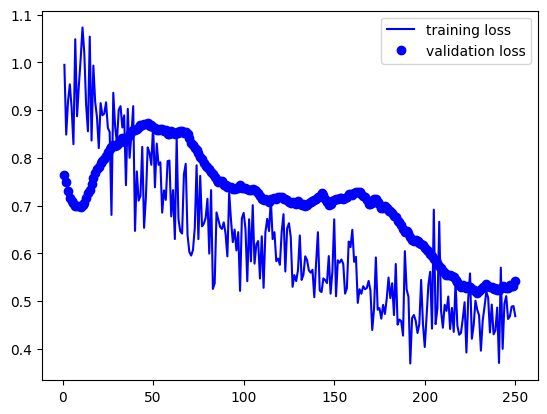

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'b',label = 'training loss')
plt.plot(epochs,val_loss,'bo',label = 'validation loss')

plt.legend()
plt.show()


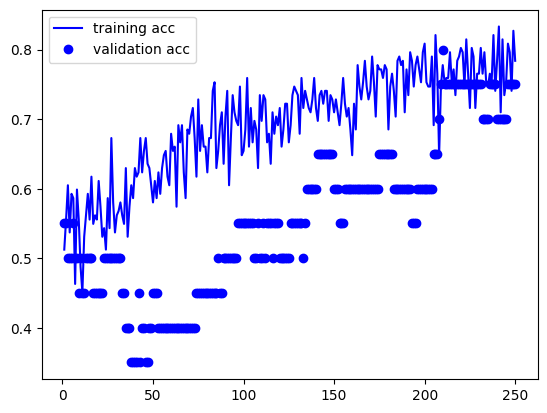

In [ ]:
plt.plot(epochs,acc,'b',label = 'training acc')
plt.plot(epochs,val_acc,'bo',label = 'validation acc')

plt.legend()
plt.show()

In [ ]:
test_data = image_dataset_from_directory(    
    '/content/ParkinsonsData/test',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
)

Found 22 files belonging to 2 classes.


In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 1s 668ms/step - loss: 0.6983 - accuracy: 0.5455


[0.6983299255371094, 0.5454545617103577]